In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Get frame file data for all sessions

In [2]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [3]:
session_filter_list = ['classinsight-cmu_05681A_ghc_4301_201905011630',
 'classinsight-cmu_05681A_ghc_4301_201904171630',
 'classinsight-cmu_05681A_ghc_4301_201902201630',
 'classinsight-cmu_05681A_ghc_4301_201904101630',
 'classinsight-cmu_05681A_ghc_4301_201901231630',
                       
 'classinsight-cmu_05418A_ghc_4102_201902251200',
 'classinsight-cmu_05418A_ghc_4102_201904081200',
 'classinsight-cmu_05418A_ghc_4102_201905011200',
 'classinsight-cmu_05418A_ghc_4102_201904291200',
 'classinsight-cmu_05418A_ghc_4102_201904011200',
                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 'classinsight-cmu_21127J_ghc_4102_201904230930',
 'classinsight-cmu_21127J_ghc_4102_201903260930',
 'classinsight-cmu_21127J_ghc_4102_201904160930',
 'classinsight-cmu_21127J_ghc_4102_201904300930',
 'classinsight-cmu_21127J_ghc_4102_201903190930',
                       
 'classinsight-cmu_05410A_ghc_4301_201904151500',
 'classinsight-cmu_05410A_ghc_4301_201902251500',
 'classinsight-cmu_05410A_ghc_4301_201904081500',
 'classinsight-cmu_05410A_ghc_4301_201904221500',
 'classinsight-cmu_05410A_ghc_4301_201902181500',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201904031130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
                       
 'classinsight-cmu_05410B_ghc_4211_201902111500',
 'classinsight-cmu_05410B_ghc_4211_201903181500',
 'classinsight-cmu_05410B_ghc_4211_201904081500',
 'classinsight-cmu_05410B_ghc_4211_201904151500',
 'classinsight-cmu_05410B_ghc_4211_201904221500',
 'classinsight-cmu_05410B_ghc_4211_201901281500'
]

# Get vizualization for single session

In [4]:
sample_course = '05410B'
sample_session_id = 'classinsight-cmu_05410B_ghc_4211_201903181500-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//05410B/classinsight-cmu_05410B_ghc_4211_201903181500-front'

In [5]:
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1

sprint(eligible_id_map_dict)

# correct created eligible map for once more
for key in sorted(list(eligible_id_map_dict.keys())):
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict) 
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
sprint("replacing ids in old to new id maps")
for old_id in old_to_new_id_map:
    if old_to_new_id_map[old_id] in eligible_id_map_dict:
        print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
        old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 


0 94
2 15
9 86
12 50
19 50
28 94
33 92
33 97
34 94
43 86
43 94
52 94
58 86
58 94
60 92
63 86
63 94
65 94
66 92
66 97
71 94
77 96
79 85
79 86
79 94
83 92
83 97
Dict: eligible_id_map_dict
Key: Value


{15: 2,
 19: 12,
 28: 0,
 34: 0,
 43: 0,
 50: 12,
 52: 0,
 58: 0,
 60: 33,
 63: 0,
 65: 0,
 66: 33,
 71: 0,
 79: 0,
 83: 33,
 85: 79,
 86: 9,
 92: 33,
 94: 0,
 96: 77,
 97: 33}

Dict: eligible_id_map_dict
Key: Value


{15: 2,
 19: 12,
 28: 0,
 34: 0,
 43: 0,
 50: 12,
 52: 0,
 58: 0,
 60: 33,
 63: 0,
 65: 0,
 66: 33,
 71: 0,
 79: 0,
 83: 33,
 85: 0,
 86: 9,
 92: 33,
 94: 0,
 96: 77,
 97: 33}

"replacing ids in old to new id maps" : replacing ids in old to new id maps
replacing 17:15 -->2
replacing 88:19 -->12
replacing 269:28 -->0
replacing 884:34 -->0
replacing 1589:43 -->0
replacing 2092:50 -->12
replacing 2182:52 -->0
replacing 2632:58 -->0
replacing 2781:60 -->33
replacing 3375:63 -->0
replacing 3473:65 -->0
replacing 3513:66 -->33
replacing 4357:71 -->0
replacing 4705:79 -->0
replacing 5119:83 -->33
replacing 5230:85 -->0
replacing 5236:86 -->9
replacing 5735:92 -->33
replacing 5750:94 -->0
replacing 5875:96 -->77
replacing 5966:97 -->33
replacing 1718:19 -->12
replacing 2071:43 -->0
replacing 3254:60 -->33
replacing 3549:60 -->33
replacing 5404:65 -->0
replacing 4829:60 -->33
replacing 4609:71 -->0
replacing 5210:71 -->0
replacing 4910:79 -->0
replacing 5447:83 -->33
replacing 5456:86 -->9
replacing 5960:92 -->33
replacing 5910:92 -->33
replacing 6080:97 -->33


In [6]:
# map processed ids to tracking df
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[old_id].where(~df_tracking_new[old_id].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




In [7]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,46416,48387,1971
1,1,0,22731,22731
2,2,24954,38214,13260
3,3,0,25053,25053
4,4,0,2526,2526
...,...,...,...,...
72,89,54567,55683,1116
73,90,54732,55686,954
74,91,54765,55767,1002
75,93,57204,58578,1374


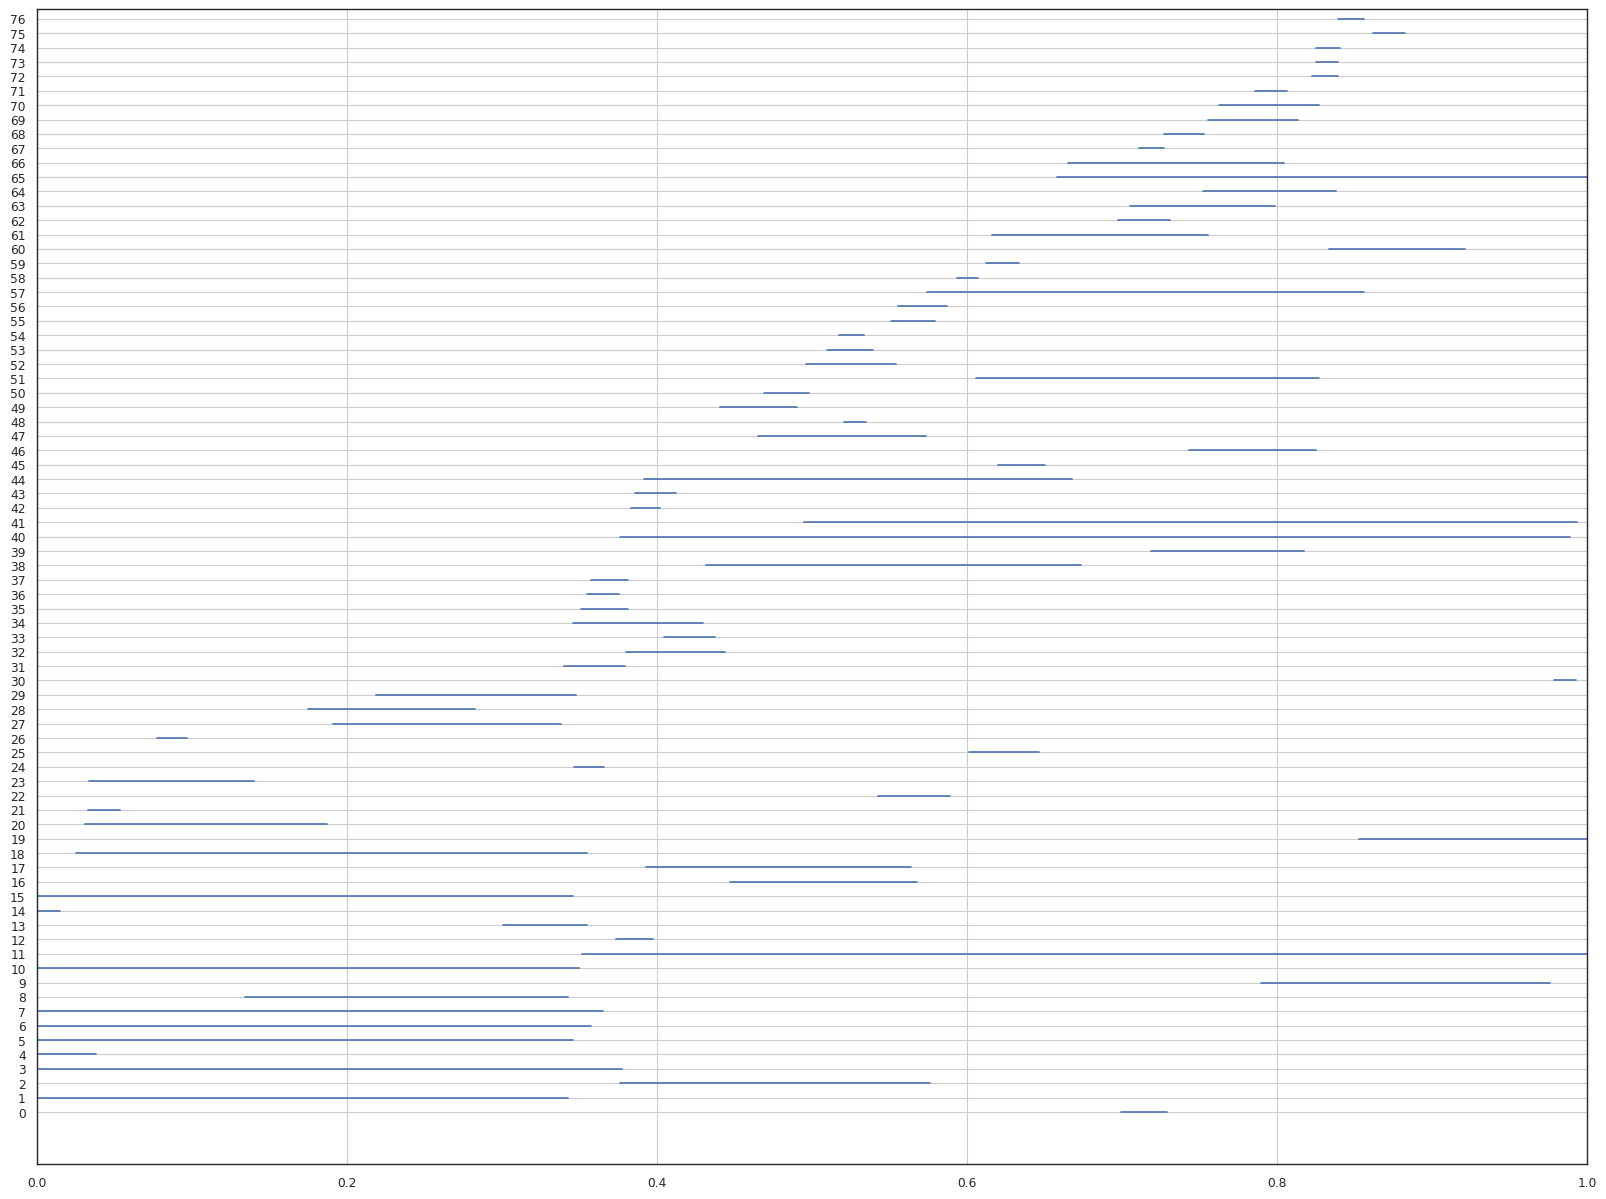

In [8]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [9]:
session_frames = df_tracking_new.index.values.tolist()
session_ids_covered = []
selected_frames = []
segments = []
segment_half_size = 50
for row_idx, row in df_id_start_stop.sort_values(by='total_idxs').iterrows():
    id_start, id_stop = row['min_idx'],row['max_idx']
    seg_mid = (id_start+id_stop)/2
    seg_start, seg_end = max(seg_mid-segment_half_size, 0), min(seg_mid+segment_half_size, total_idxs)
    is_id_covered = df_id_start_stop.apply(lambda row: (seg_end<=row['max_idx']) & (seg_start>=row['min_idx']),axis=1)
    seg_ids_covered = df_id_start_stop[is_id_covered]['id']
    new_ids_covered = [xr for xr in seg_ids_covered if xr not in session_ids_covered]
    if len(new_ids_covered)>0:        
        segment_frames = [xr for xr in session_frames if ((xr>=seg_start) and (xr<=seg_end))]
        selected_frames+=segment_frames
        segments.append((seg_start, seg_end, new_ids_covered, segment_frames))
        session_ids_covered+=new_ids_covered

sprint(segments)
    
    


List: segments


[
    (
        39773.5,
        39873.5,
        [11, 42, 45, 46, 49, 69, 70],
        [
            39774,
            39777,
            39780,
            39783,
            39786,
            39789,
            39792,
            39795,
            39798,
            39801,
            39804,
            39807,
            39810,
            39813,
            39816,
            39819,
            39822,
            39825,
            39828,
            39831,
            39834,
            39837,
            39840,
            39843,
            39846,
            39849,
            39852,
            39855,
            39858,
            39861,
            39864,
            39867,
            39870,
            39873
        ]
    ),
    (
        65356.0,
        65456.0,
        [21, 33, 78],
        [
            65358,
            65361,
            65364,
            65367,
            65370,
            65373,
            65376,
            65379,
            65382,
            65385,
            65388,
            65391,
            65394,
            65397,
            65400,
            65403,
            65406,
            65409,
            65412,
            65415,
            65418,
            65421,
            65424,
            65427,
            65430,
            65433,
            65436,
            65439,
            65442,
            65445,
            65448,
            65451,
            65454
        ]
    ),
    (
        34960.0,
        35060.0,
        [2, 17, 18, 54, 55, 61, 62, 64],
        [
            34962,
            34965,
            34968,
            34971,
            34974,
            34977,
            34980,
            34983,
            34986,
            34989,
            34992,
            34995,
            34998,
            35001,
            35004,
            35007,
            35010,
            35013,
            35016,
            35019,
            35022,
            35025,
            35028,
            35031,
            35034,
            35037,
            35040,
            35043,
            35046,
            35049,
            35052,
            35055,
            35058
        ]
    ),
    (
        55159.0,
        55259.0,
        [9, 77, 89, 90, 91],
        [
            55161,
            55164,
            55167,
            55170,
            55173,
            55176,
            55179,
            55182,
            55185,
            55188,
            55191,
            55194,
            55197,
            55200,
            55203,
            55206,
            55209,
            55212,
            55215,
            55218,
            55221,
            55224,
            55227,
            55230,
            55233,
            55236,
            55239,
            55242,
            55245,
            55248,
            55251,
            55254,
            55257
        ]
    ),
    (
        439.0,
        539.0,
        [1, 3, 4, 5, 6, 7, 10, 14, 16],
        [
            441,
            444,
            447,
            450,
            453,
            456,
            459,
            462,
            465,
            468,
            471,
            474,
            477,
            480,
            483,
            486,
            489,
            492,
            495,
            498,
            501,
            504,
            507,
            510,
            513,
            516,
            519,
            522,
            525,
            528,
            531,
            534,
            537
        ]
    ),
    (
        47668.0,
        47768.0,
        [0, 59, 74, 75, 76, 80, 81],
        [
            47670,
            47673,
            47676,
            47679,
            47682,
            47685,
            47688,
            47691,
            47694,
            47697,
            47700,
            47703,
            47706,
            47709,
            47712,
            47715,
            47718,
    

In [10]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [11]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

[h264 @ 0xa08bc80] error while decoding MB 38 40, bytestream -9
[h264 @ 0xa08bc80] error while decoding MB 47 128, bytestream -5
[h264 @ 0xd6fe000] error while decoding MB 38 40, bytestream -9
[h264 @ 0xa865e80] error while decoding MB 47 128, bytestream -5
[h264 @ 0xd6fe000] error while decoding MB 38 40, bytestream -9
[h264 @ 0xa865e80] error while decoding MB 47 128, bytestream -5


Looped 0 images


[h264 @ 0xa8a2c80] error while decoding MB 143 92, bytestream -5
[h264 @ 0xa799dc0] error while decoding MB 33 94, bytestream -7
[h264 @ 0xa8a2c80] error while decoding MB 33 65, bytestream -7
[h264 @ 0xa865e80] error while decoding MB 182 67, bytestream -9
[h264 @ 0xb131fc0] error while decoding MB 194 29, bytestream -7
[h264 @ 0xa799dc0] error while decoding MB 109 56, bytestream -11
[h264 @ 0xa8b7180] error while decoding MB 106 50, bytestream -7
[h264 @ 0xa851a80] error while decoding MB 108 61, bytestream -9
[h264 @ 0xb131fc0] error while decoding MB 134 64, bytestream -9
[h264 @ 0xa8a2c80] error while decoding MB 134 109, bytestream -7
[h264 @ 0xa851a80] error while decoding MB 95 60, bytestream -5
[h264 @ 0xa799dc0] error while decoding MB 222 76, bytestream -15
[h264 @ 0xa09af40] error while decoding MB 186 57, bytestream -7
[h264 @ 0xb131fc0] error while decoding MB 170 81, bytestream -5
[h264 @ 0xa83d680] cabac decode of qscale diff failed at 67 59
[h264 @ 0xa83d680] error wh

Looped 10000 images


[h264 @ 0xa8a2c80] error while decoding MB 22 64, bytestream -5
[h264 @ 0xa865e80] error while decoding MB 55 79, bytestream -5
[h264 @ 0xa09af40] error while decoding MB 107 30, bytestream -29
[h264 @ 0xa8a2c80] error while decoding MB 185 50, bytestream -9
[h264 @ 0xa799dc0] error while decoding MB 143 31, bytestream -8
[h264 @ 0xa8dfb80] error while decoding MB 192 51, bytestream -7
[h264 @ 0xa865e80] error while decoding MB 6 35, bytestream -6
[h264 @ 0xd6fe000] error while decoding MB 28 66, bytestream -5
[h264 @ 0xa8b7180] error while decoding MB 120 105, bytestream -24
[h264 @ 0xa8dfb80] error while decoding MB 140 114, bytestream -11
[h264 @ 0xa851a80] error while decoding MB 200 37, bytestream -5
[h264 @ 0xa799dc0] error while decoding MB 169 44, bytestream -19
[h264 @ 0xb15a9c0] error while decoding MB 204 69, bytestream -7
[h264 @ 0xa865e80] error while decoding MB 93 52, bytestream -5
[h264 @ 0xb15a9c0] error while decoding MB 145 7, bytestream -5
[h264 @ 0xa83d680] error w

Looped 20000 images


[h264 @ 0xa8dfb80] error while decoding MB 18 62, bytestream -9
[h264 @ 0xa8a2c80] error while decoding MB 106 60, bytestream -7
[h264 @ 0xa83d680] error while decoding MB 103 56, bytestream -5
[h264 @ 0xb15a9c0] error while decoding MB 177 80, bytestream -5
[h264 @ 0xa851a80] error while decoding MB 205 68, bytestream -7
[h264 @ 0xb15a9c0] error while decoding MB 26 93, bytestream -9
[h264 @ 0xa8b7180] error while decoding MB 239 76, bytestream -9
[h264 @ 0xb131fc0] error while decoding MB 234 80, bytestream -5
[h264 @ 0xa09af40] cabac decode of qscale diff failed at 150 41
[h264 @ 0xa09af40] error while decoding MB 150 41, bytestream 224932
[h264 @ 0xa87a280] error while decoding MB 14 84, bytestream -5
[h264 @ 0xa09af40] error while decoding MB 23 71, bytestream -9
[h264 @ 0xa8b7180] error while decoding MB 37 85, bytestream -5
[h264 @ 0xa851a80] error while decoding MB 20 86, bytestream -7
[h264 @ 0xa8b7180] error while decoding MB 163 49, bytestream -5
[h264 @ 0xb15a9c0] error whi

Looped 30000 images


[h264 @ 0xa8dfb80] error while decoding MB 157 22, bytestream -10
[h264 @ 0xb15a9c0] error while decoding MB 84 33, bytestream -8
[h264 @ 0xa88e780] error while decoding MB 179 67, bytestream -5
[h264 @ 0xd6fe000] cabac decode of qscale diff failed at 132 49
[h264 @ 0xd6fe000] error while decoding MB 132 49, bytestream 9074
[h264 @ 0xa88e780] error while decoding MB 165 50, bytestream -7
[h264 @ 0xa8dfb80] error while decoding MB 10 75, bytestream -9
[h264 @ 0xb1464c0] error while decoding MB 28 105, bytestream -7
[h264 @ 0xa0a6400] error while decoding MB 136 70, bytestream -13
[h264 @ 0xa851a80] error while decoding MB 127 54, bytestream -5
[h264 @ 0xa09af40] error while decoding MB 234 88, bytestream -5
[h264 @ 0xa83d680] error while decoding MB 174 57, bytestream -7
[h264 @ 0xa865e80] mmco: unref short failure
[h264 @ 0xa865e80] illegal short term buffer state detected
[h264 @ 0xb131fc0] error while decoding MB 202 75, bytestream -5
[h264 @ 0xa865e80] error while decoding MB 29 69,

Looped 40000 images


[h264 @ 0xb15a9c0] error while decoding MB 35 73, bytestream -5
[h264 @ 0xa87a280] left block unavailable for requested intra mode
[h264 @ 0xa87a280] error while decoding MB 0 20, bytestream 13563
[h264 @ 0xa88e780] error while decoding MB 33 75, bytestream -5
[h264 @ 0xa8a2c80] error while decoding MB 45 62, bytestream -9
[h264 @ 0xb15a9c0] error while decoding MB 40 51, bytestream -5
[h264 @ 0xa88e780] error while decoding MB 207 64, bytestream -9
[h264 @ 0xa87a280] error while decoding MB 90 57, bytestream -7
[h264 @ 0xa88e780] error while decoding MB 142 92, bytestream -5
[h264 @ 0xa8cb680] error while decoding MB 66 46, bytestream -5
[h264 @ 0xa8b7180] error while decoding MB 8 103, bytestream -9
[h264 @ 0xa87a280] error while decoding MB 156 68, bytestream -9
[h264 @ 0xa799dc0] error while decoding MB 38 73, bytestream -7
[h264 @ 0xa87a280] error while decoding MB 36 67, bytestream -7
[h264 @ 0xd6fe000] error while decoding MB 21 69, bytestream -9
[h264 @ 0xb131fc0] error while d

Looped 50000 images


[h264 @ 0xa0a6400] error while decoding MB 3 107, bytestream -7
[h264 @ 0xa8cb680] error while decoding MB 160 84, bytestream -5
[h264 @ 0xb15a9c0] error while decoding MB 34 23, bytestream -5
[h264 @ 0xa865e80] error while decoding MB 184 52, bytestream -5
[h264 @ 0xb1464c0] error while decoding MB 166 73, bytestream -11
[h264 @ 0xa8b7180] error while decoding MB 84 51, bytestream -9
[h264 @ 0xa09af40] error while decoding MB 115 62, bytestream -5
[h264 @ 0xa09af40] error while decoding MB 140 60, bytestream -7
[h264 @ 0xa851a80] error while decoding MB 35 52, bytestream -5
[h264 @ 0xa09af40] error while decoding MB 86 69, bytestream -5
[h264 @ 0xa8a2c80] error while decoding MB 86 51, bytestream -5
[h264 @ 0xa8dfb80] error while decoding MB 124 50, bytestream -5
[h264 @ 0xa0a6400] error while decoding MB 23 75, bytestream -5
[h264 @ 0xa8b7180] error while decoding MB 19 64, bytestream -7
[h264 @ 0xa865e80] error while decoding MB 132 48, bytestream -9
[h264 @ 0xa799dc0] error while d

Looped 60000 images


[h264 @ 0xa0a6400] error while decoding MB 98 79, bytestream -5
[h264 @ 0xa83d680] cabac decode of qscale diff failed at 91 49
[h264 @ 0xa83d680] error while decoding MB 91 49, bytestream 127014
[h264 @ 0xa87a280] error while decoding MB 109 88, bytestream -7
[h264 @ 0xa09af40] error while decoding MB 34 69, bytestream -5
[h264 @ 0xa865e80] error while decoding MB 24 39, bytestream -5
[h264 @ 0xa09af40] cabac decode of qscale diff failed at 222 21
[h264 @ 0xa09af40] error while decoding MB 222 21, bytestream 134398
[h264 @ 0xa09af40] error while decoding MB 40 85, bytestream -5
[h264 @ 0xa8b7180] error while decoding MB 46 18, bytestream -12
[h264 @ 0xa851a80] error while decoding MB 183 53, bytestream -7
[h264 @ 0xa8cb680] error while decoding MB 192 85, bytestream -5
[h264 @ 0xb1464c0] error while decoding MB 131 116, bytestream -5
[h264 @ 0xd6fe000] error while decoding MB 32 88, bytestream -7
[h264 @ 0xa8b7180] error while decoding MB 96 5, bytestream -10
[h264 @ 0xa83d680] error w

In [12]:
session_id_viz_dir = f'{id_viz_cache_root}/{sample_session_id}'
os.makedirs(session_id_viz_dir, exist_ok=True)
tracking_model =None
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, new_ids_covered, segment_frames) in enumerate(segments):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}_{"_".join(map(str,new_ids_covered))}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                frame_tracking_results[person_idx]['track_id'] =old_to_new_id_map[old_id]
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
            else:
                cv2.imwrite(frame_file_out,frame_img)
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=5, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

2023-09-03 20:28:59,550 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-09-03 20:28:59,721 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-09-03 20:28:59,722 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-03 20:28:59,724 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-03 20:29:01,983 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector